In [1]:
#!/usr/bin/env python
# coding: utf-8

# ## Caricamento dati

# In[1]:


import time
#import logging
#logging.basicConfig()
#logging.getLogger().setLevel(logging.DEBUG)

start = time.time()
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKerasTF
import funzioni as fz
import importlib
from collections import Counter
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
import pickle
from tensorflow.keras.layers import Dense, Input, Conv1D, Dropout, MaxPooling1D, Flatten, concatenate, AveragePooling1D
from tensorflow.keras.models import Model
gpus = tf.config.experimental.list_physical_devices('GPU')
from tensorflow.keras.utils import plot_model
from sklearn import preprocessing

print(gpus)
if gpus:
  # Restrict TensorFlow to only use the second GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)


from tensorflow.keras.layers import Conv1D, Activation, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def print_count(labels):
    c=Counter(labels)
    print(sorted(c.items()))
    tot=sum(c.values())
    for item in c.items():
        print(item[0], round(item[1]/tot*100, 2), '%')

data=pd.read_pickle('/data1/Domenico/alldatatype.pkl')
#data1=pd.read_pickle('/data1/Domenico/alldatatype.ino.pkl')
#data2=pd.read_pickle('/data1/Domenico/alldatatype.notino.pkl')
#data = pd.DataFrame(np.concatenate([data1, data2]), columns=data1.columns)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
cut = 2250
X=data.iloc[:,0:2250]
y=data.iloc[:,3251:]
y['class']=y.apply(np.argmax, axis=1)
print_count(y['class'])

scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(data = scaler.fit_transform(X.values.T).T, columns = X.columns)
y=y['class']


def build_park_model():
    keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
    filters = 80
    kernel_size=200
    subsample_length = 2
    model=None
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters, kernel_size, subsample_length, padding = 'same', input_shape=(X.shape[1],1))) 
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.AveragePooling1D(3, strides=None)) 
    model.add(Lambda(lambda v: tf.cast(tf.signal.fft(tf.cast(v,dtype=tf.complex64)),tf.float32)))
    model.add(keras.layers.Conv1D(filters*2, int(kernel_size/2), subsample_length, padding = 'same')) 
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.AveragePooling1D(3, strides=None)) 
    model.add(keras.layers.Conv1D(filters*3, int(kernel_size/4), subsample_length, padding = 'same')) 
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.AveragePooling1D(3, strides=None)) 
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=2800,activation='relu', kernel_regularizer='l2')) #Aggiunto
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(units=1400,activation='relu', kernel_regularizer='l2')) #Aggiunto
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(units=700,activation='relu',kernel_regularizer='l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(units=70,activation='relu',kernel_regularizer='l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(units=7, activation='softmax'))

    optimizer = keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

/home/domenico/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[(0, 66643), (1, 15999), (2, 184929), (3, 12803), (4, 8146), (5, 92261), (6, 16554)]
0 16.77 %
3 3.22 %
1 4.03 %
2 46.54 %
5 23.22 %
4 2.05 %
6 4.17 %


## Training

In [3]:
X.head()

,5.0,5.02,5.04,5.06,5.08,5.1,5.12,5.14,5.16,5.18,...,49.8,49.82,49.84,49.86,49.88,49.9,49.92,49.94,49.96,49.98
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008640,0.012297,0.018003,0.027188,0.042419,0.068359,0.113020,0.188248,0.303424,0.442022
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000006,0.000006,0.000007,0.000009
2,0.0,0.000002,0.000002,0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000219,0.000214,0.000226,0.000257,0.000312,0.000401,0.000541,0.000766,0.001130,0.001736
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000021,0.000021,0.000022,0.000026,0.000032,0.000042,0.000059,0.000089,0.000136,0.000202
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001


In [4]:
sampling_strategy_under = {0: 50000, 2: 50000, 5:50000}
sampling_strategy_over = {1:40000, 3: 40000, 4:40000, 6:40000}
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)
over = RandomOverSampler(sampling_strategy=sampling_strategy_over)

In [5]:
X, y = under.fit_resample(X, y)

In [6]:
X, y = over.fit_resample(X, y)

In [7]:
model=build_park_model()
X=X.values
X=X.reshape(X.shape[0], X.shape[1], 1)

In [8]:
print_count(y)

[(0, 50000), (1, 40000), (2, 50000), (3, 40000), (4, 40000), (5, 50000), (6, 40000)]
0 16.13 %
1 12.9 %
2 16.13 %
3 12.9 %
4 12.9 %
5 16.13 %
6 12.9 %


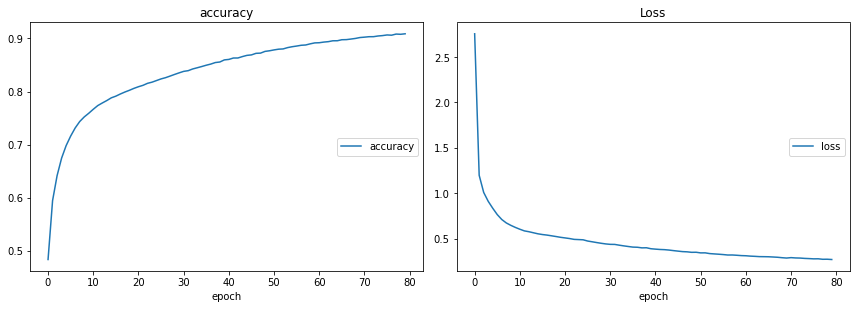

accuracy
	accuracy         	 (min:    0.483, max:    0.909, cur:    0.909)
Loss
	loss             	 (min:    0.270, max:    2.753, cur:    0.270)
310000/310000 [==============================] - 138s 447us/sample - loss: 0.2700 - accuracy: 0.9089


In [9]:
plotlosses = PlotLossesKerasTF()

#early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=0, mode='min')
#model_checkpoint = keras.callbacks.ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(X, y, batch_size = 200, verbose = 1, epochs=80, callbacks=[plotlosses], shuffle=True)

In [10]:
scores = model.evaluate(X, y, verbose=0)

In [11]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.31%


In [12]:
model.save("model.h5")

## Test

In [13]:
from tensorflow.keras.models import load_model
 
# load model
loaded_model = load_model('model.h5')
# summarize model.
loaded_model.summary()
# evaluate the model
score = loaded_model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1125, 80)          16080     
_________________________________________________________________
activation (Activation)      (None, 1125, 80)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1125, 80)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 375, 80)           0         
_________________________________________________________________
lambda (Lambda)              (None, 375, 80)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 160)          1280160   
_________________________________________________________________
activation_1 (Activation)    (None, 188, 160)          0

In [14]:
X.shape

(310000, 2250, 1)

In [15]:
y.shape

(310000,)

In [16]:
y

0         0
1         0
2         0
3         0
4         0
         ..
309995    6
309996    6
309997    6
309998    6
309999    6
Name: class, Length: 310000, dtype: int64

In [17]:
y_new=loaded_model.predict(X)

In [18]:
y_new

array([[9.93101954e-01, 1.74174493e-04, 6.68278523e-03, ...,
        4.63067272e-06, 2.25440126e-05, 8.81531719e-07],
       [9.82349575e-01, 4.06849384e-03, 1.20614432e-02, ...,
        5.34210587e-04, 2.38292065e-04, 2.64159862e-05],
       [9.27629173e-01, 2.22375765e-02, 2.56426893e-02, ...,
        1.45157445e-02, 2.01705727e-03, 5.30736987e-04],
       ...,
       [1.36074996e-05, 2.60002702e-03, 6.76252739e-06, ...,
        2.08623931e-07, 8.15446128e-07, 9.97327447e-01],
       [6.13610354e-08, 1.22653641e-04, 2.57185118e-08, ...,
        3.12302806e-09, 4.39600978e-09, 9.99872565e-01],
       [5.76230173e-04, 5.65815601e-04, 3.14864039e-04, ...,
        3.99341094e-09, 1.96119959e-06, 9.98520195e-01]], dtype=float32)